In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from vincenty import vincenty

from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.datasets import fetch_mldata
from sklearn.utils import shuffle

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [11]:
#Import natural disaster data
raw = pd.read_csv('natural_disaster_human_mobility.csv')

In [12]:
#Switch latitude and longtitude columns, rename and reorder, dataframe
df = raw
df = df.rename(columns = {'disaster.event': 'event', 'user.anon': 'user', 'latitude': 'long', 'longitude.anon': 'lat'})
df = df[['event', 'user', 'lat', 'long', 'time']]
df['time'] = pd.DatetimeIndex(df['time'])


In [13]:
#Calculate event location by averaging the first lat long entry for each user
group = df.groupby(by = 'event').mean()
group

,user,lat,long
event,,,
01_Wipha,24368.338734,28.391620,139.668645
02_Halong,2482.137684,43.006657,127.762166
06_Kalmaegi,591.625357,5.342795,120.410101
08_Rammasun_Manila,17102.932522,9.572405,120.997554
12_Bohol,3805.313771,-2.370050,123.860556
13_Iquique,781.068314,-18.004903,-70.133271
14_Napa,888.637865,34.441945,-122.302310
21_Norfolk,4276.517602,69.428469,1.132364
22_Hamburg,1428.430413,63.611212,10.002712


In [14]:
#Export average coordinates to csv for tableau
group.to_csv('ave_coord.csv')

In [15]:
napa2 = df[(df['event'] == '14_Napa')]
napa2.shape
napa2.to_csv('napa2.csv')
napa2.head()

,event,user,lat,long,time
2579280,14_Napa,1,34.476407,-122.271651,2014-08-23 16:53:23
2579281,14_Napa,1,34.476850,-122.271929,2014-08-23 18:36:07
2579282,14_Napa,2,34.429233,-122.292902,2014-08-24 03:26:05
2579283,14_Napa,3,34.448051,-122.311231,2014-07-30 13:05:52
2579284,14_Napa,3,34.448052,-122.311114,2014-07-30 13:39:35


In [183]:
napa = df[(df['event'] == '14_Napa')]

In [184]:
#Generate distance column
napa['lat_1'] = napa['lat'].shift()
napa['long_1'] = napa['long'].shift()
napa['dist_mi'] = napa.apply(lambda row: vincenty((row['lat'], row['long']), (row['lat_1'], row['long_1'])), axis=1)
napa['dist_ft'] = napa['dist_mi']*5260

/Users/mattcarney/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/mattcarney/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mattcarney/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [185]:
napa['time_diff'] = napa['time'].diff()
napa['time_diff_hour'] = napa['time_diff']/np.timedelta64(1, 'h')
napa['time_diff_day'] = napa['time_diff']/np.timedelta64(1, 'D')

/Users/mattcarney/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/mattcarney/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/mattcarney/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [186]:
napa['velocity_mph'] = napa['dist_mi']/napa['time_diff_hour'] 

/Users/mattcarney/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [187]:
napa['dist_cent'] = napa.apply(lambda row: vincenty((row['lat'], row['long']), \
                                                    (napa['lat'].mean(), napa['long'].mean())), axis=1)


/Users/mattcarney/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [21]:
napa.to_csv('napa.csv')

In [194]:
napa['date'] = napa['time'].dt.date
napa['date'] = pd.to_datetime(napa['date'])

/Users/mattcarney/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/mattcarney/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [195]:
#napa['disaster_day'] = napa.where(napa['date'] == '2014-08-24')
napa['disaster_day'] = napa['date'].map(lambda x: 1 if x== '2014-08-24' else 0)

/Users/mattcarney/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [203]:
napa['disaster_day'] = (napa['date'] == '2014-08-24')
#sol['Completed'] = (sol['Installed Status'] == 'Installed').astype(int) 

/Users/mattcarney/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [204]:
napa.head(300)

,event,user,lat,long,time,lat_1,long_1,dist_mi,dist_ft,time_diff,time_diff_hour,time_diff_day,velocity_mph,dist_cent,date,disaster_day
2579280,14_Napa,1,34.476407,-122.271651,2014-08-23 16:53:23,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,4.748723,2014-08-23,False
2579281,14_Napa,1,34.476850,-122.271929,2014-08-23 18:36:07,34.476407,-122.271651,0.055382,291.30932,0 days 01:42:44,1.712222,0.071343,0.032345,4.773385,2014-08-23,False
2579282,14_Napa,2,34.429233,-122.292902,2014-08-24 03:26:05,34.476850,-122.271929,5.622784,29575.84384,0 days 08:49:58,8.832778,0.368032,0.636582,1.654181,2014-08-24,True
2579283,14_Napa,3,34.448051,-122.311231,2014-07-30 13:05:52,34.429233,-122.292902,2.682419,14109.52394,-25 days +09:39:47,-590.336944,-24.597373,-0.004544,1.063424,2014-07-30,False
2579284,14_Napa,3,34.448052,-122.311114,2014-07-30 13:39:35,34.448051,-122.311231,0.010753,56.56078,0 days 00:33:43,0.561944,0.023414,0.019135,1.055228,2014-07-30,False
2579285,14_Napa,3,34.448061,-122.311166,2014-07-30 13:52:43,34.448052,-122.311114,0.004882,25.67932,0 days 00:13:08,0.218889,0.009120,0.022304,1.059536,2014-07-30,False
2579286,14_Napa,3,34.448056,-122.311181,2014-07-30 13:56:19,34.448061,-122.311166,0.001486,7.81636,0 days 00:03:36,0.060000,0.002500,0.024767,1.060240,2014-07-30,False
2579287,14_Napa,3,34.447890,-122.310961,2014-07-30 14:30:14,34.448056,-122.311181,0.027347,143.84522,0 days 00:33:55,0.565278,0.023553,0.048378,1.032922,2014-07-30,False
2579288,14_Napa,3,34.447836,-122.311191,2014-07-30 18:06:35,34.447890,-122.310961,0.021969,115.55694,0 days 03:36:21,3.605833,0.150243,0.006093,1.045524,2014-07-30,False
2579289,14_Napa,3,34.448093,-122.311134,2014-07-30 19:02:57,34.447836,-122.311191,0.028986,152.46636,0 days 00:56:22,0.939444,0.039144,0.030854,1.059560,2014-07-30,False


In [197]:
napa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38019 entries, 2579280 to 2617298
Data columns (total 16 columns):
event             38019 non-null object
user              38019 non-null int64
lat               38019 non-null float64
long              38019 non-null float64
time              38019 non-null datetime64[ns]
lat_1             38018 non-null float64
long_1            38018 non-null float64
dist_mi           38018 non-null float64
dist_ft           38018 non-null float64
time_diff         38018 non-null timedelta64[ns]
time_diff_hour    38018 non-null float64
time_diff_day     38018 non-null float64
velocity_mph      37997 non-null float64
dist_cent         38019 non-null float64
date              38019 non-null datetime64[ns]
disaster_day      38019 non-null int64
dtypes: datetime64[ns](2), float64(10), int64(2), object(1), timedelta64[ns](1)
memory usage: 4.9+ MB


In [208]:
napa_group_user = napa.groupby(['user', 'date', 'disaster_day']).mean()
napa_group_user

lat        long      lat_1      long_1  \
user date       disaster_day                                                 
1    2014-08-23 False         34.476629 -122.271790  34.476407 -122.271651   
2    2014-08-24 True          34.429233 -122.292902  34.476850 -122.271929   
3    2014-07-30 False         34.447994 -122.311197  34.446959 -122.310176   
     2014-07-31 False         34.444002 -122.309014  34.444004 -122.309017   
     2014-08-01 False         34.441611 -122.304328  34.441611 -122.304327   
     2014-08-02 False         34.448013 -122.311230  34.448604 -122.310771   
     2014-08-03 False         34.448731 -122.309451  34.448728 -122.309443   
     2014-08-04 False         34.447978 -122.311239  34.447982 -122.311249   
     2014-08-05 False         34.447317 -122.308578  34.447309 -122.308562   
     2014-08-06 False         34.447921 -122.311261  34.447932 -122.311279   
     2014-08-07 False         34.450605 -122.279904  34.450602 -122.279902   
     2014-08-08 False         34.447998 -122.311260  34.447994 -122.311256   
     2014-08-09 False         34.445330 -122.298101  34.445657 -122.299766   
     2014-08-10 False         34.447966 -122.311259  34.447695 -122.309819   
     2014-08-11 False         34.447968 -122.311259  34.447955 -122.311263   
     2014-08-12 False         34.446349 -122.309155  34.446350 -122.309153   
     2014-08-13 False         34.447700 -122.310102  34.447696 -122.310106   
     2014-08-14 False         34.451168 -122.309911  34.451175 -122.309907   
     2014-08-15 False         34.445343 -122.310477  34.445334 -122.310479   
     2014-08-16 False         34.440758 -122.306787  34.440763 -122.306790   
     2014-08-17 False         34.447997 -122.311224  34.447972 -122.311217   
     2014-08-18 False         34.450759 -122.304261  34.450761 -122.304261   
     2014-08-19 False         34.453596 -122.309500  34.453596 -122.309500   
     2014-08-20 False         34.453010 -122.309600  34.453003 -122.309593   
     2014-08-21 False         34.452430 -122.307467  34.452439 -122.307468   
     2014-08-22 False         34.451160 -122.304692  34.451152 -122.304692   
     2014-08-23 False         34.449229 -122.307800  34.449235 -122.307800   
     2014-08-24 True          34.447758 -122.310861  34.447755 -122.310869   
     2014-08-25 False         34.447975 -122.311168  34.447960 -122.311185   
     2014-08-26 False         34.449350 -122.310047  34.449354 -122.310040   
     2014-08-27 False         34.453873 -122.309384  34.453868 -122.309384   
     2014-08-28 False         34.454410 -122.309485  34.454412 -122.309488   
     2014-08-29 False         34.459349 -122.306352  34.458845 -122.306744   
4    2014-08-03 False         34.478534 -122.268409  34.477860 -122.269322   
5    2014-08-24 True          34.427100 -122.310745  34.480989 -122.266513   
6    2014-08-04 False         34.379095 -122.273829  34.395089 -122.286149   
7    2014-07-30 False         34.426876 -122.300961  34.417460 -122.295517   
     2014-07-31 False         34.473197 -122.328217  34.471335 -122.327076   
     2014-08-01 False         34.433784 -122.309153  34.432599 -122.308442   
     2014-08-02 False         34.431175 -122.306958  34.427939 -122.305334   
     2014-08-03 False         34.465668 -122.323662  34.465696 -122.323669   
     2014-08-04 False         34.428693 -122.305583  34.430183 -122.306471   
     2014-08-05 False         34.463131 -122.322288  34.463148 -122.322256   
     2014-08-07 False         34.408590 -122.295590  34.413269 -122.297726   
     2014-08-08 False         34.408222 -122.297599  34.412870 -122.299782   
     2014-08-09 False         34.436254 -122.304196  34.432984 -122.302899   
     2014-08-10 False         34.435845 -122.308756  34.435845 -122.308751   
     2014-08-11 False         34.413242 -122.297827  34.417916 -122.299942   
     2014-08-12 False         34.450744 -122.314605  34.429711 -122.305107   
     2014-08-14 False         34.413942 -122.296744  34.41

In [189]:

#pd.to_datetime(napa['time'],format = '%m/%d/%Y')

/Users/mattcarney/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [127]:
napa_group = napa.groupby(by = 'date').mean().reset_index()
napa_group

,date,user,lat,long,lat_1,long_1,dist_mi,dist_ft,time_diff_hour,time_diff_day,velocity_mph,dist_cent
0,2014-07-30,824.750450,34.443703,-122.304345,34.442362,-122.303509,1.071967,5638.544591,-61.437436,-2.559893,1.604734,2.127420
1,2014-07-31,908.339607,34.441810,-122.301823,34.441836,-122.301394,0.555668,2922.813819,-58.847101,-2.451963,1.107948,2.599750
2,2014-08-01,873.465636,34.444151,-122.303227,34.443680,-122.303351,0.743947,3913.161911,-80.987721,-3.374488,1.660990,2.556203
3,2014-08-02,901.144660,34.442128,-122.303153,34.442244,-122.303142,0.960555,5052.517288,-73.889059,-3.078711,1.500869,2.606075
4,2014-08-03,807.402695,34.443532,-122.303605,34.443905,-122.303235,0.656283,3452.050808,-31.334980,-1.305624,1.500495,2.453716
5,2014-08-04,864.852655,34.444408,-122.305311,34.444489,-122.305421,0.545808,2870.947755,-15.695508,-0.653979,1.065412,2.327731
6,2014-08-05,862.764947,34.440970,-122.302830,34.441184,-122.303232,0.667300,3509.997319,-24.498910,-1.020788,1.489472,2.516614
7,2014-08-06,888.158717,34.444428,-122.304272,34.444075,-122.304385,0.557472,2932.301055,-2.343527,-0.097647,0.745735,2.021708
8,2014-08-07,786.499585,34.442443,-122.304268,34.442649,-122.304291,0.619013,3256.010584,-9.286736,-0.386947,1.083028,2.515795
9,2014-08-08,746.298762,34.442890,-122.303759,34.442162,-122.303367,0.815451,4289.272553,-1.882081,-0.078420,inf,2.372104


In [109]:
napa_group.info()

user               890.699146
lat                 34.442306
long              -122.302244
lat_1               34.442170
long_1            -122.302304
dist_mi              0.742985
dist_ft           3908.099181
time_diff_hour      -0.698840
time_diff_day       -0.029118
velocity_mph              inf
dist_cent            2.518521
dtype: float64

In [25]:
napa_group3 = napa_group.reset_index()
napa_group3

,date,user,lat,long,lat_1,long_1,dist_mi,dist_ft,time_diff_hour,time_diff_day,velocity_mph
0,2014-07-30,824.750450,34.443703,-122.304345,34.442362,-122.303509,1.071967,5638.544591,-61.437436,-2.559893,1.604734
1,2014-07-31,908.339607,34.441810,-122.301823,34.441836,-122.301394,0.555668,2922.813819,-58.847101,-2.451963,1.107948
2,2014-08-01,873.465636,34.444151,-122.303227,34.443680,-122.303351,0.743947,3913.161911,-80.987721,-3.374488,1.660990
3,2014-08-02,901.144660,34.442128,-122.303153,34.442244,-122.303142,0.960555,5052.517288,-73.889059,-3.078711,1.500869
4,2014-08-03,807.402695,34.443532,-122.303605,34.443905,-122.303235,0.656283,3452.050808,-31.334980,-1.305624,1.500495
5,2014-08-04,864.852655,34.444408,-122.305311,34.444489,-122.305421,0.545808,2870.947755,-15.695508,-0.653979,1.065412
6,2014-08-05,862.764947,34.440970,-122.302830,34.441184,-122.303232,0.667300,3509.997319,-24.498910,-1.020788,1.489472
7,2014-08-06,888.158717,34.444428,-122.304272,34.444075,-122.304385,0.557472,2932.301055,-2.343527,-0.097647,0.745735
8,2014-08-07,786.499585,34.442443,-122.304268,34.442649,-122.304291,0.619013,3256.010584,-9.286736,-0.386947,1.083028
9,2014-08-08,746.298762,34.442890,-122.303759,34.442162,-122.303367,0.815451,4289.272553,-1.882081,-0.078420,inf


In [26]:
napa_group2 = napa.groupby(by = 'date').size()
napa_group2

date
2014-07-30    1110
2014-07-31    1169
2014-08-01    1164
2014-08-02    1030
2014-08-03    1336
2014-08-04    1337
2014-08-05    1221
2014-08-06    1216
2014-08-07    1205
2014-08-08    1292
2014-08-09    1089
2014-08-10    1055
2014-08-11    1251
2014-08-12    1198
2014-08-13    1158
2014-08-14    1083
2014-08-15    1087
2014-08-16    1037
2014-08-17    1019
2014-08-18    1025
2014-08-19    1011
2014-08-20    1259
2014-08-21    1132
2014-08-22     983
2014-08-23    1155
2014-08-24    2871
2014-08-25    1516
2014-08-26    1677
2014-08-27    1179
2014-08-28    1150
2014-08-29     993
2014-08-30      11
dtype: int64

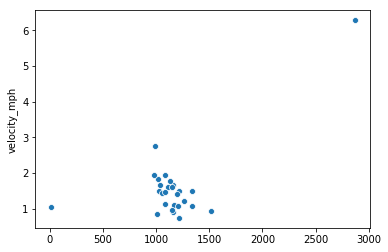

In [27]:
sns.scatterplot(x=napa_group2, y=napa_group['velocity_mph'])

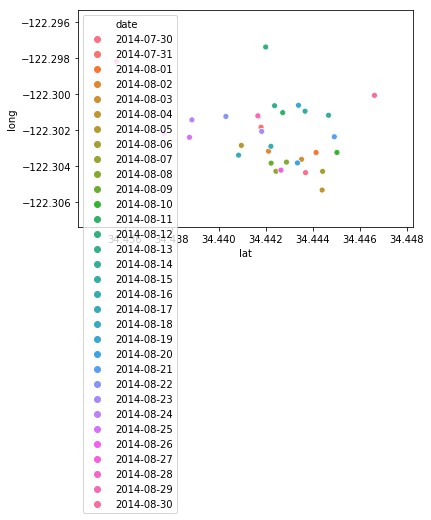

In [28]:
sns.scatterplot(x=napa_group3['lat'], y=napa_group3['long'], hue=napa_group3['date'])

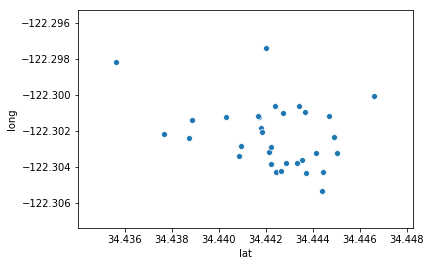

In [29]:
sns.scatterplot(x=napa_group3['lat'], y=napa_group3['long'])

In [79]:
X = np.append(napa_group3['lat'],napa_group3['long']).transpose()

In [87]:
X = napa_group3[['lat', 'long']]

In [88]:
X = X.as_matrix()

/Users/mattcarney/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [89]:
X.shape

(32, 2)

In [90]:
#helper function that allows us to display data in 2 dimensions an highlights the clusters
def display_cluster(X,km=[],num_clusters=0):
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

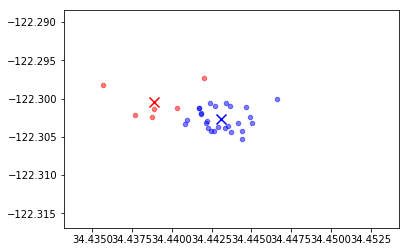

In [117]:
num_clusters = 2
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=1) # n_init, number of times the K-mean algorithm will run
km.fit(X)
display_cluster(X,km,num_clusters)

In [55]:
km.cluster_centers_

array([[  34.44309583, -122.30265756],
       [  34.43888329, -122.30045171]])

In [114]:
km.inertia_

9.687890343101427e-05

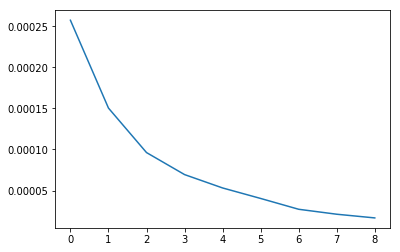

In [115]:
plt.plot([KMeans(n_clusters=i).fit(X).inertia_ for i in range(1,10)])